# Graph 5
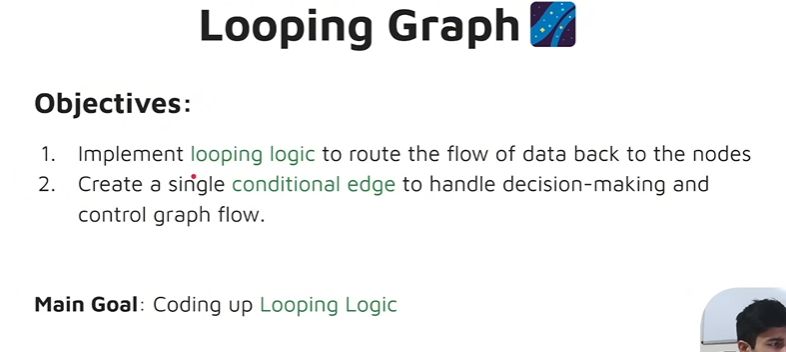

In [4]:
from typing import TypedDict, List
from  langgraph.graph import StateGraph, START, END
import random

In [5]:
class AgentState(TypedDict):
    name: str
    number: List[int]
    counter : int

In [10]:
def greeting_node(state:AgentState) -> AgentState:
    """Greeting node which says hi to the person"""
    state["name"] = f"Hi there, {state["name"]}"
    return state

def random_node(state:AgentState) -> AgentState:
    """Generates a random number from 0 to 10"""
    state["number"].append(random.randint(0,10))
    state["counter"] += 1
    return state

def should_continue(state:AgentState) -> AgentState:
    """Function to decide what to do next"""
    if state["counter"] < 5:
        print("Entering Loop", state["counter"])
        return "loop"   # Continue looping
    else:
        return "exit"   # Exit the loop


In [11]:
graph = StateGraph(AgentState)

graph.add_node("greeting", greeting_node)
graph.add_node("random", random_node)
graph.add_edge("greeting", "random")

graph.add_conditional_edges(
    "random",        # Source node
    should_continue, # Routing Function
    {
        "loop" : "random",  # self-loop back to same node
        "exit" : END        # End the graph
    }
)

graph.set_entry_point("greeting")

app = graph.compile()

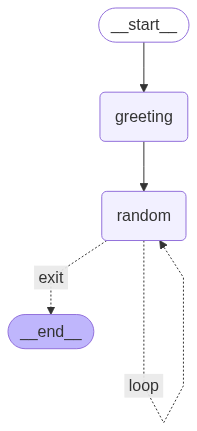

In [12]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [25]:
app.invoke({"name":"Prathik", "number":[], "counter":-1})

Entering Loop 0
Entering Loop 1
Entering Loop 2
Entering Loop 3
Entering Loop 4


{'name': 'Hi there, Prathik', 'number': [5, 2, 4, 8, 2, 9], 'counter': 5}

# Graph 5
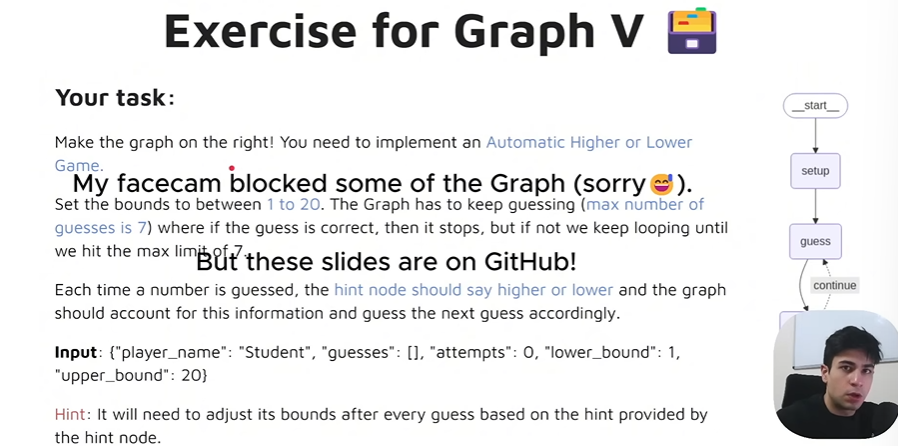

In [31]:
from typing import TypedDict, List, Dict
from langgraph.graph import StateGraph, START, END
import random

In [32]:
class GameState(TypedDict):
    player_name : str
    guesses :List[int]
    attempts : int
    target_number: int
    hint: str
    lower_bound : int
    upper_bound: int
    

In [33]:
def setup_node(state:GameState) -> GameState:
    """Initialize the game with a random target number"""
    state["player_name"] = f"Welcome, {state['player_name']}!"
    state["guesses"] = []
    state["target_number"] = random.randint(1, 20)
    state["attempts"] = 0
    state["hint"] = "Game started! Try to guess the number."
    state["lower_bound"] = 0
    state["upper_bound"] = 20
    print(f"{state['player_name']} The game begun. I'm thinking of a number between 1 and 20.")
    return state

In [34]:
def guess_node(state:GameState) -> GameState:
    """Generate a smarter guess based on previous hints"""
    possible_guesses = [i for i in range(state["lower_bound"], state["upper_bound"] +1) if i not in state["guesses"]]
    if possible_guesses:
        guess = random.choice(possible_guesses)
    else:
        guess = random.randint(state["lower_bound"], state["upper_bound"])

    state["guesses"].append(guess)
    state["attempts"] += 1
    print(f"Attempt {state["attempts"]}: Guessing {guess} (Current range:{state['lower_bound']} - {state['upper_bound']})")
    return state

In [35]:
def hint_node(state: GameState) -> GameState:
    """Here we provide a hint based on the last guess and update the bounds"""
    latest_guess = state["guesses"][-1]
    target = state["target_number"]

    if latest_guess < target:
        state["hint"] = f"The number{latest_guess} is too low. Try higher!"
        state["lower_bound"] = max(state["lower_bound"], latest_guess + 1)
        print(f"Hint: {state['hint']}")
        
    elif latest_guess > target:
        state["hint"] = f"The number {latest_guess} is too high. Try lower!"
      
        state["upper_bound"] = min(state["upper_bound"], latest_guess - 1)
        print(f"Hint: {state['hint']}")
    else:
        state["hint"] = f"Correct! You found the number {target} in {state['attempts']} attempts."
        print(f"Success! {state['hint']}")
    
    return state

In [36]:
def should_continue(state: GameState) -> str:
    """Determine if we should continue guessing or end the game"""
    
    # There are 2 end conditions - either 7 is reached or the correct number is guessed
    
    latest_guess = state["guesses"][-1]
    if latest_guess == state["target_number"]:
        print(f"GAME OVER: Number found!")
        return "end"
    elif state["attempts"] >= 7:
        print(f"GAME OVER: Maximum attempts reached! The number was {state['target_number']}")
        return "end"
    else:
        print(f"CONTINUING: {state['attempts']}/7 attempts used")
        return "continue"

In [37]:
graph = StateGraph(GameState)
graph.add_node("setup", setup_node)
graph.add_node("guess", guess_node)
graph.add_node("hint_node", hint_node)

graph.add_edge("setup", "guess")
graph.add_edge("guess", "hint_node")

graph.add_conditional_edges(
    "hint_node",
    should_continue,
    {
        "continue":"guess",
        "end" : END
    }
)

graph.set_entry_point("setup")
app = graph.compile()

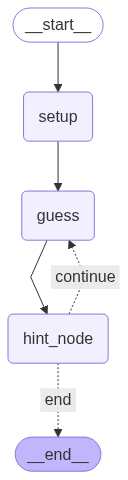

In [38]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [42]:
result = app.invoke({"player_name":"Student", "guesses":[], "attempts": 0, "lower_bound":1, "upper_bound": 20})
result

Welcome, Student! The game begun. I'm thinking of a number between 1 and 20.
Attempt 1: Guessing 2 (Current range:0 - 20)
Hint: The number2 is too low. Try higher!
CONTINUING: 1/7 attempts used
Attempt 2: Guessing 12 (Current range:3 - 20)
Hint: The number 12 is too high. Try lower!
CONTINUING: 2/7 attempts used
Attempt 3: Guessing 7 (Current range:3 - 11)
Hint: The number7 is too low. Try higher!
CONTINUING: 3/7 attempts used
Attempt 4: Guessing 8 (Current range:8 - 11)
Hint: The number8 is too low. Try higher!
CONTINUING: 4/7 attempts used
Attempt 5: Guessing 11 (Current range:9 - 11)
Hint: The number 11 is too high. Try lower!
CONTINUING: 5/7 attempts used
Attempt 6: Guessing 10 (Current range:9 - 10)
Hint: The number 10 is too high. Try lower!
CONTINUING: 6/7 attempts used
Attempt 7: Guessing 9 (Current range:9 - 9)
Success! Correct! You found the number 9 in 7 attempts.
GAME OVER: Number found!


{'player_name': 'Welcome, Student!',
 'guesses': [2, 12, 7, 8, 11, 10, 9],
 'attempts': 7,
 'target_number': 9,
 'hint': 'Correct! You found the number 9 in 7 attempts.',
 'lower_bound': 9,
 'upper_bound': 9}